# Lab Session 4 - Task A: VSM for Word Similarity
Imports and Setup

In [1]:
import os
import re
from collections import Counter
import numpy as np
import pandas as pd
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from scipy.sparse import lil_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

print("Setup Complete")


Setup Complete


Data Loading and Preprocessing

In [2]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stop_words and len(word) > 2]


def load_data(folder_path):
    all_docs = []
    categories = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    print(f"Found categories: {categories}")
    
    for category in tqdm(categories, desc="Loading categories"):
        category_path = os.path.join(folder_path, category)
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    text = f.read()
                    processed_doc = preprocess_text(text)
                    if processed_doc:
                        all_docs.append(processed_doc)
            except Exception as e:
                print(f"Could not read {file_path}: {e}")
    return all_docs

BBC_FOLDER = 'bbc'
documents = load_data(BBC_FOLDER)
print(f"\nLoaded and processed {len(documents)} documents.")

Found categories: ['business', 'entertainment', 'politics', 'sport', 'tech']


Loading categories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


Loaded and processed 2225 documents.


Build Co-occurrence Matrix

In [3]:
VOCAB_SIZE = 10000
WINDOW_SIZE = 5  

all_tokens = [token for doc in documents for token in doc]
word_counts = Counter(all_tokens)
vocab = [word for word, count in word_counts.most_common(VOCAB_SIZE)]

word_to_id = {word: i for i, word in enumerate(vocab)}
id_to_word = {i: word for i, word in enumerate(vocab)}
vocab_set = set(vocab)
print(f"Vocabulary size: {len(vocab)}")

cooc_matrix = lil_matrix((VOCAB_SIZE, VOCAB_SIZE), dtype=np.float32)

for doc in tqdm(documents, desc="Building Co-occurrence Matrix"):
    doc_indices = [word_to_id[word] for word in doc if word in vocab_set]
    for i, target_idx in enumerate(doc_indices):
        start = max(0, i - WINDOW_SIZE)
        end = min(len(doc_indices), i + WINDOW_SIZE + 1)
        context_indices = doc_indices[start:i] + doc_indices[i+1:end]
        for context_idx in context_indices:
            cooc_matrix[target_idx, context_idx] += 1

print("Co-occurrence matrix built.")

Vocabulary size: 10000


Building Co-occurrence Matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2225/2225 [00:17<00:00, 125.46it/s]

Co-occurrence matrix built.


Apply PPMI Weighting

In [4]:
def calculate_ppmi(matrix):
    matrix_csr = matrix.tocsr()
    
    total_cooccurrences = matrix_csr.sum()
    if total_cooccurrences == 0:
        return lil_matrix(matrix.shape, dtype=np.float32)
    
    word_totals = np.array(matrix_csr.sum(axis=1)).flatten()
    context_totals = np.array(matrix_csr.sum(axis=0)).flatten()
    
    p_wc = matrix_csr / total_cooccurrences
    p_w = word_totals / total_cooccurrences
    p_c = context_totals / total_cooccurrences

    ppmi_matrix = lil_matrix(matrix.shape, dtype=np.float32)
    rows, cols = matrix_csr.nonzero()
    
    for r, c in tqdm(zip(rows, cols), desc="Calculating PPMI", total=len(rows)):
        if p_w[r] > 0 and p_c[c] > 0:
            pmi = np.log2(p_wc[r, c] / (p_w[r] * p_c[c]))
            ppmi_matrix[r, c] = max(0, pmi)
            
    return ppmi_matrix


ppmi_matrix = calculate_ppmi(cooc_matrix)
print("\n Task A.a Result ")
print(f"The dimensions of the final PPMI matrix are: {ppmi_matrix.shape}")


Calculating PPMI: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2416672/2416672 [00:48<00:00, 49691.92it/s]


 Task A.a Result 
The dimensions of the final PPMI matrix are: (10000, 10000)


Apply Truncated SVD


In [5]:
SVD_DIMENSIONS = 300

svd = TruncatedSVD(n_components=SVD_DIMENSIONS, random_state=42)
svd_matrix = svd.fit_transform(ppmi_matrix)

print(f"SVD matrix created with dimensions: {svd_matrix.shape}")


SVD matrix created with dimensions: (10000, 300)


Word Similarity Evaluation

In [6]:
def find_most_similar(query_word, matrix, word_to_id, id_to_word, top_n=5):
    """Finds the top_n most similar words to a query_word in a given matrix."""
    if query_word not in word_to_id:
        return [("Word not in vocabulary", 0)] * top_n
    
    query_id = word_to_id[query_word]
    query_vector = matrix[query_id].reshape(1, -1)
    
    sim_scores = cosine_similarity(query_vector, matrix).flatten()
    
    top_indices = np.argsort(sim_scores)[::-1][1:top_n+1]
    
    return [(id_to_word[i], sim_scores[i]) for i in top_indices]



query_words = {
    'business': 'market',
    'entertainment': 'film',
    'politics': 'election',
    'sport': 'game',
    'tech': 'software'
}

results = []
for category, word in query_words.items():
    vsm_similar = find_most_similar(word, ppmi_matrix, word_to_id, id_to_word)
    svd_similar = find_most_similar(word, svd_matrix, word_to_id, id_to_word)
    
    results.append({
        "Query Word": f"{word} ({category})",
        "Top 5 Similar Words (VSM)": ", ".join([f"{w[0]}" for w in vsm_similar]),
        "Top 5 Similar Words (SVD)": ", ".join([f"{w[0]}" for w in svd_similar])
    })

results_df = pd.DataFrame(results)
print("\nWord Similarity Results:")
print(results_df.to_string(index=False))


Word Similarity Results:
          Query Word                      Top 5 Similar Words (VSM)                    Top 5 Similar Words (SVD)
   market (business)          stock, housing, growth, prices, sales       stock, analysts, share, growth, prices
film (entertainment)         best, awards, actress, director, films          films, movie, awards, best, actress
 election (politics)        general, labour, campaign, blair, party   labour, general, partys, campaign, labours
        game (sport)           games, play, players, match, playing         play, games, players, playing, first
     software (tech) microsoft, programs, users, antivirus, windows programs, microsoft, windows, users, program


# Lab Session 4 - Task B: Word2Vec

1. Setup and Data Loading

In [7]:
import os
import re
from collections import Counter
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Data Loading and Preprocessing (from Task A) 
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stop_words and len(word) > 2]

def load_data(folder_path):
    all_docs = []
    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        if not os.path.isdir(category_path): continue
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                all_docs.append(preprocess_text(f.read()))
    return all_docs

BBC_FOLDER = 'bbc'
documents = load_data(BBC_FOLDER)

# Vocabulary Creation (from Task A) 
VOCAB_SIZE = 10000
all_tokens = [token for doc in documents for token in doc]
word_counts = Counter(all_tokens)
vocab = [word for word, count in word_counts.most_common(VOCAB_SIZE)]
word_to_id = {word: i for i, word in enumerate(vocab)}
id_to_word = {i: word for i, word in enumerate(vocab)}
vocab_set = set(vocab)

print(f"Setup complete. Vocabulary size: {len(vocab)}")

Setup complete. Vocabulary size: 10000


 2. Prepare Data for Word2Vec

In [8]:
WINDOW_SIZE = 5
NUM_NEGATIVE_SAMPLES = 5

# Generate skip-gram pairs
pairs = []
for doc in tqdm(documents, desc="Generating training pairs"):
    doc_indices = [word_to_id[word] for word in doc if word in vocab_set]
    for i, target_idx in enumerate(doc_indices):
        start = max(0, i - WINDOW_SIZE)
        end = min(len(doc_indices), i + WINDOW_SIZE + 1)
        context_indices = doc_indices[start:i] + doc_indices[i+1:end]
        for context_idx in context_indices:
            pairs.append((target_idx, context_idx))

# Prepare for negative sampling
word_freqs = np.array([word_counts[word] for word in vocab])
unigram_dist = word_freqs**0.75 / np.sum(word_freqs**0.75)
word_indices = np.arange(VOCAB_SIZE)

class Word2VecDataset(Dataset):
    def __init__(self, pairs, unigram_dist, num_negative_samples):
        self.pairs = pairs
        self.unigram_dist = unigram_dist
        self.num_negative_samples = num_negative_samples

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        target, context = self.pairs[idx]
        negative_samples = np.random.choice(word_indices, size=self.num_negative_samples, p=self.unigram_dist)
        return torch.LongTensor([target]), torch.LongTensor([context]), torch.LongTensor(negative_samples)


Generating training pairs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2225/2225 [00:01<00:00, 1830.31it/s]


3. Define the PyTorch Word2Vec Model

In [11]:
class SkipGramNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramNegativeSampling, self).__init__()
        self.in_embed = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.out_embed = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.init_embed()

    def init_embed(self):
        nn.init.uniform_(self.in_embed.weight, -0.5 / self.in_embed.embedding_dim, 0.5 / self.in_embed.embedding_dim)
        nn.init.uniform_(self.out_embed.weight, -0.5 / self.out_embed.embedding_dim, 0.5 / self.out_embed.embedding_dim)
        
    def forward(self, target_word, context_word, negative_words):
        v_target = self.in_embed(target_word)  
        v_context = self.out_embed(context_word) 
        v_negs = self.out_embed(negative_words)
        
        pos_score = torch.bmm(v_target, v_context.transpose(1, 2)).squeeze(2)
        pos_loss = -torch.log(torch.sigmoid(pos_score) + 1e-8).mean()
        
        neg_score = torch.bmm(v_target.expand(v_negs.size()), v_negs.transpose(1, 2))
        neg_loss = -torch.log(torch.sigmoid(-neg_score) + 1e-8).mean()
        
        return pos_loss + neg_loss

4. Train the Model

In [12]:
EMBEDDING_DIM = 300
BATCH_SIZE = 1024
EPOCHS = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = Word2VecDataset(pairs, unigram_dist, NUM_NEGATIVE_SAMPLES)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = SkipGramNegativeSampling(VOCAB_SIZE, EMBEDDING_DIM).to(device)
optimizer = optim.SparseAdam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    total_loss = 0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for target, context, negs in pbar:
        target, context, negs = target.to(device), context.to(device), negs.to(device)
        
        optimizer.zero_grad()
        loss = model(target, context, negs)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
    
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(dataloader)}")

word2vec_embeddings = model.in_embed.weight.cpu().detach().numpy()

Using device: cpu


Epoch 1/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4139/4139 [13:14<00:00,  5.21it/s, loss=1.22]


Epoch 1, Average Loss: 1.263701289308967


Epoch 2/2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4139/4139 [12:51<00:00,  5.37it/s, loss=1.12]

Epoch 2, Average Loss: 1.1636732804887564


5. Task B.a: Word Similarity Comparison

In [13]:
def find_most_similar(query_word, matrix, word_to_id, id_to_word, top_n=5):
    if query_word not in word_to_id:
        return [("Word not in vocabulary", 0)] * top_n
    query_id = word_to_id[query_word]
    query_vector = matrix[query_id].reshape(1, -1)
    sim_scores = cosine_similarity(query_vector, matrix).flatten()
    top_indices = np.argsort(sim_scores)[::-1][1:top_n+1]
    return [(id_to_word[i], sim_scores[i]) for i in top_indices]

query_words = ['market', 'film', 'election', 'game', 'software']
word2vec_results = []

for word in query_words:
    similar_words = find_most_similar(word, word2vec_embeddings, word_to_id, id_to_word)
    word2vec_results.append(", ".join([w[0] for w in similar_words]))

print("\n--- Word2Vec Similarity Results ---")
for q, res in zip(query_words, word2vec_results):
    print(f"{q}: {res}")


--- Word2Vec Similarity Results ---
market: stock, upsurge, panke, steadily, ferrari
film: hollywood, films, berlin, movie, tale
election: campaigning, looming, slogan, polls, manifesto
game: encounter, bruising, lively, awesome, flair
software: programmers, exeem, linux, programs, manually


6. Task B.b: Analogy Questions

In [14]:
def solve_analogy(a, b, c, matrix, word_to_id, id_to_word):
    for word in [a, b, c]:
        if word not in word_to_id:
            return f"Error: '{word}' not in vocabulary."
    vec_a = matrix[word_to_id[a]]
    vec_b = matrix[word_to_id[b]]
    vec_c = matrix[word_to_id[c]]
    result_vec = (vec_a - vec_b + vec_c).reshape(1, -1)
    sim_scores = cosine_similarity(result_vec, matrix).flatten()
    top_indices = np.argsort(sim_scores)[::-1]
    for idx in top_indices:
        word = id_to_word[idx]
        if word not in [a, b, c]:
            return word
    return "No answer found."

analogies = [
    ("business is to profit as politics is to ?", ('business', 'profit', 'politics')),
    ("britain is to london as france is to ?", ('britain', 'london', 'france')),
    ("sport is to football as tech is to ?", ('sport', 'football', 'tech')),
    ("minister is to government as player is to ?", ('minister', 'government', 'player')),
    ("movie is to entertainment as computer is to ?", ('movie', 'entertainment', 'computer'))
]

print("\n Analogy Question Results \n")
for question_text, (a, b, c) in analogies:
    answer = solve_analogy(a, b, c, word2vec_embeddings, word_to_id, id_to_word)
    print(f"{question_text}\n  -> Answer: {answer}\n")


 Analogy Question Results 

business is to profit as politics is to ?
  -> Answer: stupid

britain is to london as france is to ?
  -> Answer: germany

sport is to football as tech is to ?
  -> Answer: revamp

minister is to government as player is to ?
  -> Answer: toshack

movie is to entertainment as computer is to ?
  -> Answer: hackers



Saving all final matrices and vocabulary

In [15]:
import numpy as np
import pickle
from scipy.sparse import save_npz

print("Saving all final matrices and vocabulary...")
    
# Save the objects
save_npz('ppmi_matrix.npz', ppmi_matrix.tocsr()) 
    
np.save('svd_matrix.npy', svd_matrix)
np.save('word2vec_embeddings.npy', word2vec_embeddings)

with open('id_to_word.pkl', 'wb') as f:
    pickle.dump(id_to_word, f)
    
print("All objects saved successfully to disk.")

Saving all final matrices and vocabulary...
All objects saved successfully to disk.


# Lab Session 4 - Task C: Visualization

1. Setup and Imports 

In [16]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from tqdm import tqdm

try:
    _ = ppmi_matrix
    _ = svd_matrix
    _ = word2vec_embeddings
    _ = id_to_word
    print("Found all necessary variables from previous tasks. Ready to proceed.")
except NameError as e:
    print(f"ERROR: Could not find a required variable: {e}")
    print("Please make sure you have run the notebooks for Task A and Task B in this session first.")

Found all necessary variables from previous tasks. Ready to proceed.


2. Prepare Data for Visualization 

In [17]:
NUM_WORDS_TO_PLOT = 750

plot_indices = list(range(NUM_WORDS_TO_PLOT))
plot_words = [id_to_word[i] for i in plot_indices]

# Get the corresponding vectors from each matrix
ppmi_vectors_plot = ppmi_matrix[plot_indices, :].toarray()
svd_vectors_plot = svd_matrix[plot_indices, :]
word2vec_vectors_plot = word2vec_embeddings[plot_indices, :]

print(f"Selected {len(plot_words)} most frequent words for visualization.")

Selected 750 most frequent words for visualization.


3. Dimensionality Reduction

In [18]:
def reduce_dimensions(vectors, random_state=42):
    """Reduces dimensions of vectors using both PCA and t-SNE."""
    # PCA reduction
    pca = PCA(n_components=2, random_state=random_state)
    vectors_pca = pca.fit_transform(vectors)
    
    # t-SNE reduction - CORRECTED with max_iter
    tsne = TSNE(n_components=2, perplexity=15, random_state=random_state, max_iter=1000)
    vectors_tsne = tsne.fit_transform(vectors)
    
    return vectors_pca, vectors_tsne

print("Starting dimensionality reduction for all three models...")

# tqdm will show the progress
with tqdm(total=3, desc="Reducing Dimensions") as pbar:
    ppmi_pca, ppmi_tsne = reduce_dimensions(ppmi_vectors_plot)
    pbar.update(1)
    svd_pca, svd_tsne = reduce_dimensions(svd_vectors_plot)
    pbar.update(1)
    word2vec_pca, word2vec_tsne = reduce_dimensions(word2vec_vectors_plot)
    pbar.update(1)

print("Dimensionality reduction complete.")

Starting dimensionality reduction for all three models...


Reducing Dimensions: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.89s/it]

Dimensionality reduction complete.


4. Create Interactive Plots

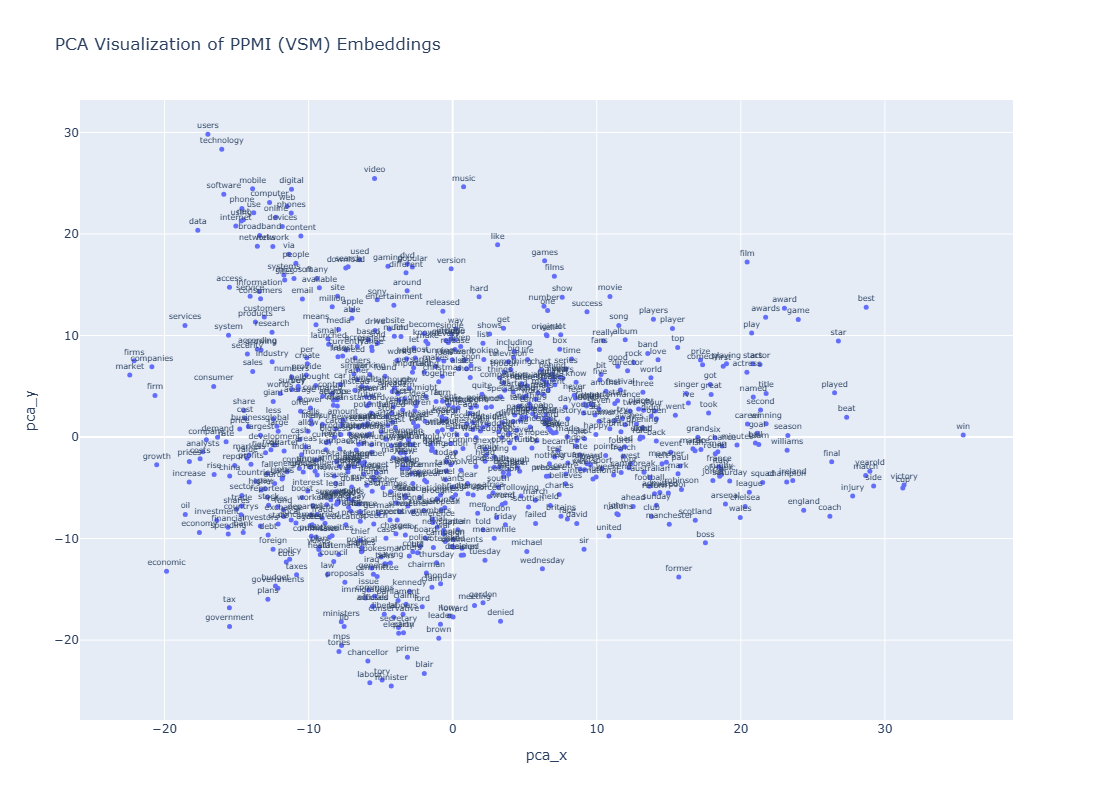

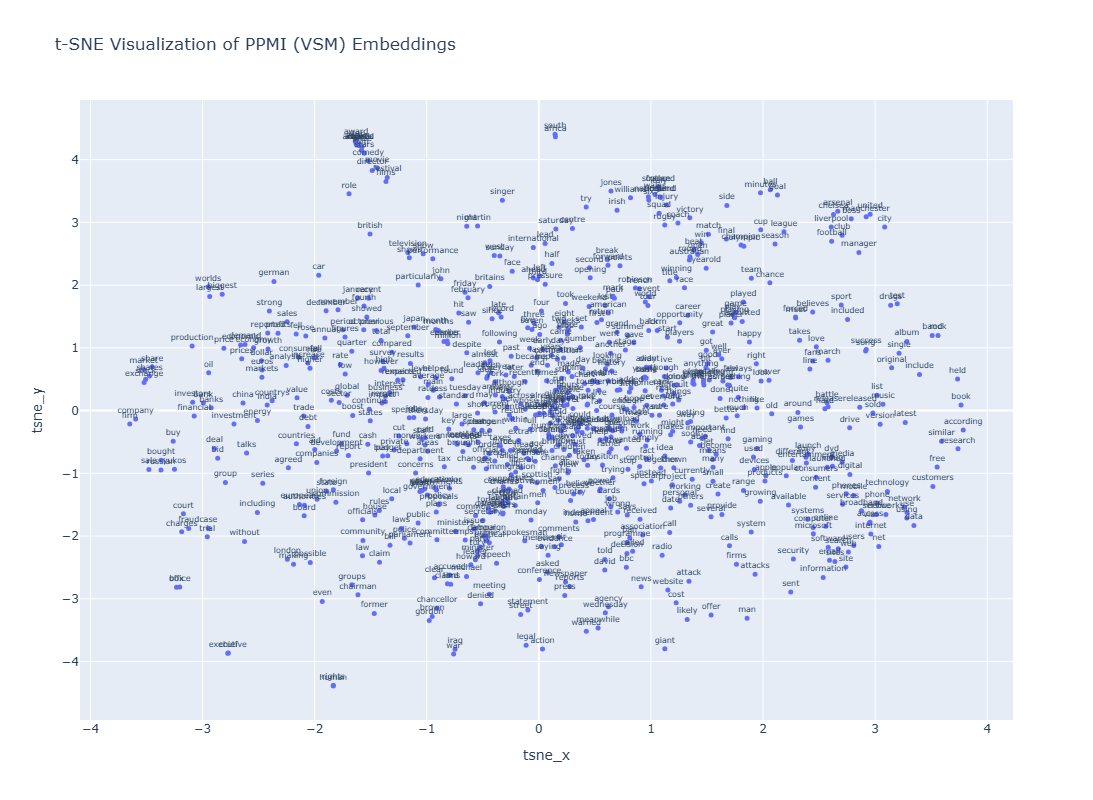

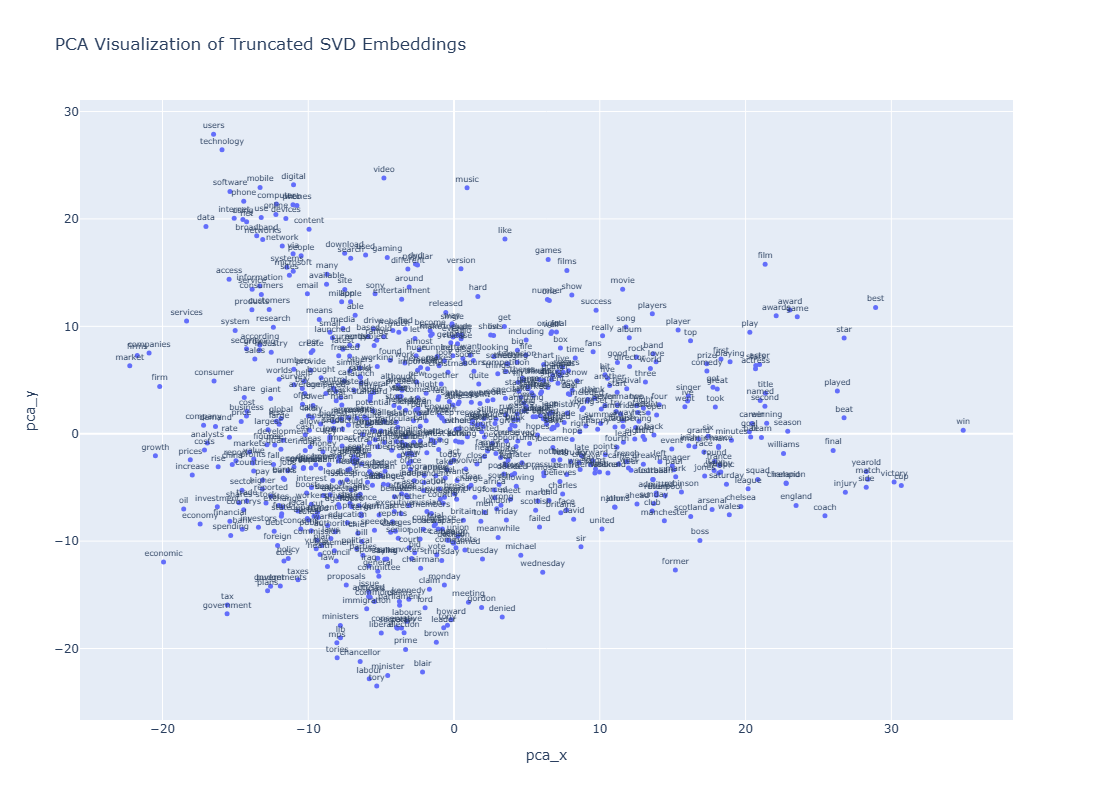

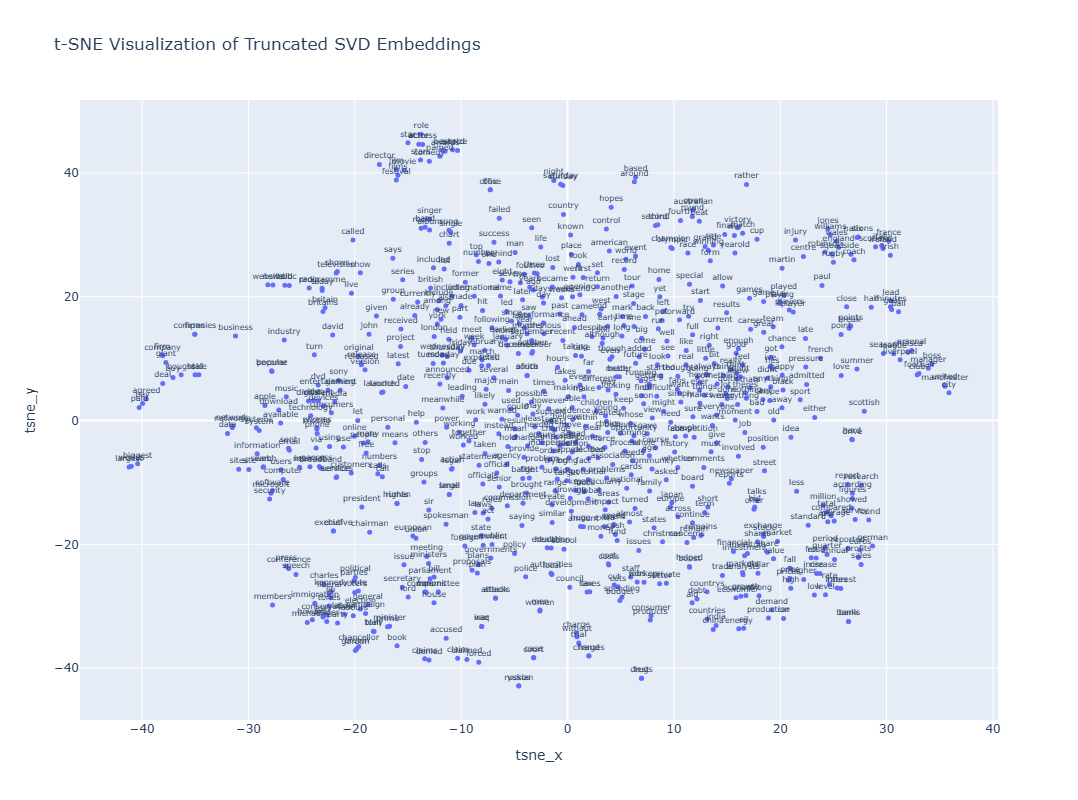

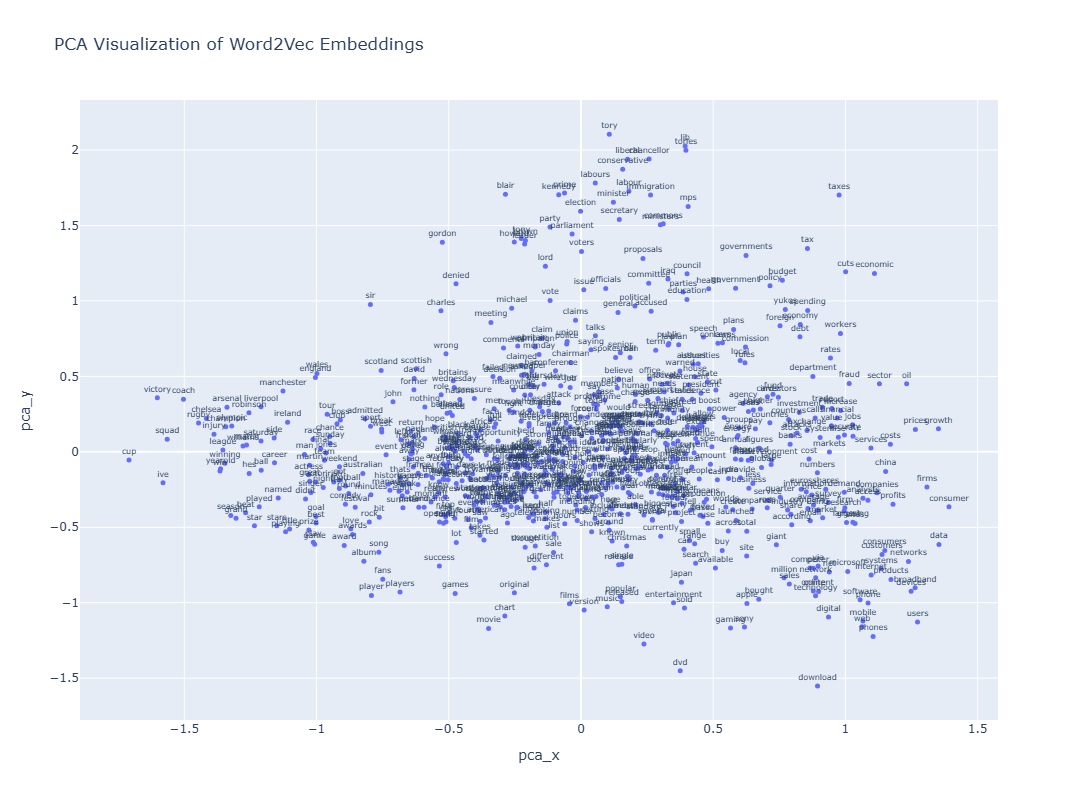

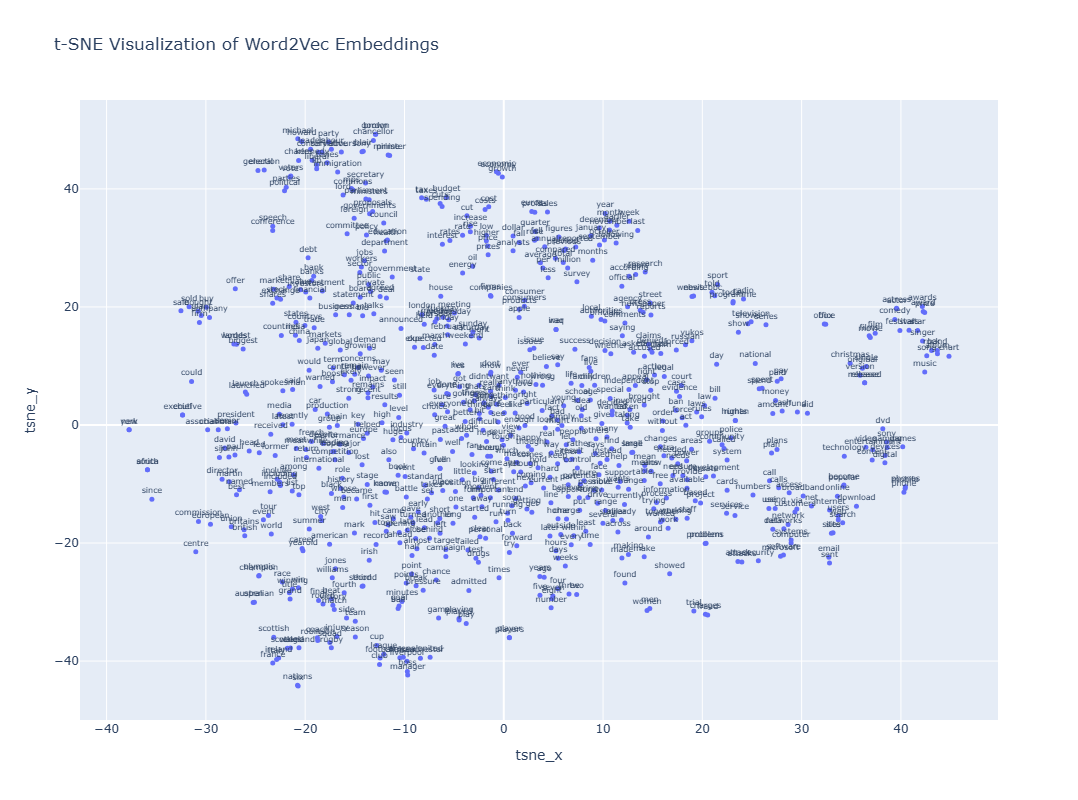

In [ ]:
 def create_plots(df, model_name):
    """Generates PCA and t-SNE plots for a given model."""
    # PCA Plot
    fig_pca = px.scatter(df, x='pca_x', y='pca_y', text='word',
                         title=f'PCA Visualization of {model_name} Embeddings')
    fig_pca.update_traces(textposition='top center', mode='markers+text', textfont_size=8, marker=dict(size=5))
    fig_pca.update_layout(height=800, width=800, showlegend=False)
    fig_pca.show()
    
    # t-SNE Plot
    fig_tsne = px.scatter(df, x='tsne_x', y='tsne_y', text='word',
                          title=f't-SNE Visualization of {model_name} Embeddings')
    fig_tsne.update_traces(textposition='top center', mode='markers+text', textfont_size=8, marker=dict(size=5))
    fig_tsne.update_layout(height=800, width=800, showlegend=False)
    fig_tsne.show()


# Create DataFrames and plot for each model
models_data = {
    'PPMI (VSM)': (ppmi_pca, ppmi_tsne),
    'Truncated SVD': (svd_pca, svd_tsne),
    'Word2Vec': (word2vec_pca, word2vec_tsne)
}

for model_name, (pca_data, tsne_data) in models_data.items():
    df = pd.DataFrame({
        'word': plot_words,
        'pca_x': pca_data[:, 0],
        'pca_y': pca_data[:, 1],
        'tsne_x': tsne_data[:, 0],
        'tsne_y': tsne_data[:, 1]
    })
    create_plots(df, model_name)